In [1]:
# Definitions and functions
%matplotlib inline
import pdb
import sys
import pandas as pd
import numpy as np
import scipy.io as sio
import matplotlib.pyplot as plt
import matplotlib
import scipy.signal as sg
import math
import scipy as sp
import socket
import os
import wave
import struct
import h5py
from scipy.io import wavfile
from scipy.signal import spectrogram
from basic_viewing import h5_functions as h5
import logging
from IPython.display import display
matplotlib.style.use('ggplot')
from ipywidgets import *
import yaml
import numpy.lib.recfunctions as rfn 
import numpy.matlib as npm
import glob

# Check wich computer to decide where the things are mounted
comp_name=socket.gethostname()
print 'Computer: ' + comp_name

if 'txori' in comp_name or 'passaro' in comp_name or 'lintu' in comp_name:
    repos_folder = os.path.abspath('/mnt/cube/earneodo/repos')
    experiment_folder = os.path.join('/mnt/cube/earneodo/bci_zf/')

sys.path.append(os.path.join(repos_folder, 'soundflow', 'sound_tools'))
sys.path.append(os.path.join(repos_folder, 'ephysflow'))
sys.path.append(os.path.join(repos_folder, 'analysis-tools'))

#setup the data folder
ss_data_folder = os.path.join(experiment_folder, 'ss_data')

import soundtools as st
import Kwik as oe
from file_tools import experiment as et
from basic_viewing import events as evt
from basic_viewing.units import Unit
from basic_viewing.basic_plot import plot_raster, sparse_raster
from basic_viewing import basic_plot as bp
from basic_viewing import kwik_functions as kwf


Computer: passaro


In [6]:
# bird and session

bird = 'z007'
sess = 'day-sleep_2016-09-09'
syn_sess = '002'

# bird = 'z017'
# sess = 'day-2016-06-18'

exp_par = et.get_parameters(bird, sess)
fn = et.file_names(bird, sess)
song_file_path = et.file_path(fn, 'ss', 'sng')
song_file = h5py.File(song_file_path, 'r')

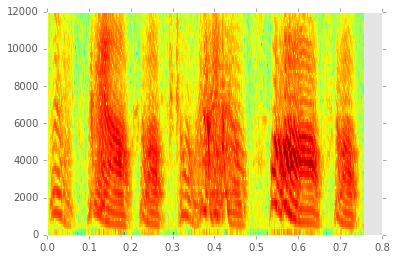

In [7]:
#pattern
m_name = 'bos_tag'
m_path = os.path.join(et.file_names(bird)['folders']['stim'], 
                      exp_par['search_motiff']['motiff_patterns'][m_name])

m = evt.Song(m_name, song_file)
m_chunk = st.Chunk(st.WavData2(m_path))
m_length = m_chunk.samples
#plt.plot(m_chunk.data)

m_control = evt.Song('bos_rev_tag', song_file)

n_window = 192
n_overlap = 191
sigma = 0.001 * 30000
f_cut = 12000
s_f = m_chunk.sound.s_f

pattern_spectrogram = spectrogram(m_chunk.data[:,0], s_f, 
                                  nperseg = n_window, 
                                  noverlap= n_overlap, 
                                  window = sg.gaussian(n_window, sigma), 
                                  scaling='spectrum')

plt.pcolormesh(pattern_spectrogram[1], 
               pattern_spectrogram[0][pattern_spectrogram[0] < f_cut], 
               np.log(pattern_spectrogram[2][pattern_spectrogram[0] < f_cut, :]))

In [32]:
from __future__ import division
from scipy.signal import resample

def normalize(x):
    x_normed = (x - x.min(0)) / x.ptp(0)
    return x_normed

def stream_resample(stream, s_f, new_s_f):
    n_samples = stream.shape[0]
    new_samples = int(n_samples * new_s_f/s_f)
    return resample(stream, new_samples)

def load_syn_stream(bird, syn_sess=1, s_f=44100, new_s_f=30000, file_base='synth_bos'):
    stim_folder = et.file_names(bird)['folders']['stim']
    syn_file = os.path.join(stim_folder, str(syn_sess).zfill(3), file_base + '.dat')
    return stream_resample(np.loadtxt(syn_file), s_f, new_s_f)

def load_alpha_beta(bird, syn_sess=1, s_f=44100, new_s_f=30000, first=None):
    syn_par = load_syn_stream(bird, syn_sess=syn_sess, s_f=s_f, new_s_f=new_s_f)
    bos = load_syn_stream(bird, syn_sess=syn_sess, s_f=s_f, new_s_f=new_s_f, file_base='bos')
    env_bos = load_syn_stream(bird, syn_sess=syn_sess, s_f=s_f, new_s_f=new_s_f, file_base='env_bos')
    
    first = syn_par.shape[0] if first is None else first
    
    alpha = syn_par[:first,2]
    alpha[alpha>0] = 0
    alpha[alpha<0] = 0.3

    # equivalent to -alpha + 0.15 but getting rid of high frequency
    #env = st.envelope(bos[:alpha.shape[0]], window=300, conv_mode='same')
    env = env_bos[:first, 2]
    beta = -(syn_par[:first,1])
    beta[beta<0] = 0
    return (alpha), (beta), env

def plot_spectrogram(x, before_ms, after_ms, s_f, n_window = 192, n_overlap = None, sigma=None, ax=None, **kwargs):
    
    if n_overlap is None:
        n_overlap = n_window/2
    if sigma is None:
        sigma = 1./1000.*s_f
    
    # Make the spectrogram
    f, t, Sxx = spectrogram(x, s_f, nperseg = n_window, noverlap=n_overlap, window = sg.gaussian(n_window, sigma), scaling='spectrum')
    
    span_before = np.zeros((Sxx.shape[0], np.int(before_ms/1000. * s_f)))
    span_after = np.zeros((Sxx.shape[0], np.int(after_ms/1000. * s_f) - Sxx.shape[1]))
    span_before[:] = np.nan
    span_after[:] = np.nan
    #Sxx = np.hstack((span_before, (Sxx), span_after))
    
    if ax is None:
        spec_fig = plt.figure()
        ax = spec_fig.add_axes([0, 0, 1, 1])
        
    ax.pcolormesh(((t-0.5*n_window/s_f)*1000.), f, np.log(Sxx))
    ax.set_xlim(-before_ms, after_ms)
    ax.set_ylim(0,10000)
    #ax.plot((span_before.shape[1], span_before.shape[1]), (np.min(f), np.max(f)), 'k--')
    
    return Sxx, ax

n_samples = m_chunk.samples
syn_par = load_syn_stream(bird, syn_sess=syn_sess)[:n_samples,:]
bos = load_syn_stream(bird, file_base='bos', syn_sess=syn_sess)[:n_samples,]
synth_bos = load_syn_stream(bird, file_base='song_synth_bos', syn_sess=syn_sess)[:n_samples,]
alpha, beta, env = load_alpha_beta(bird, first=n_samples, syn_sess=syn_sess)

plt.plot(alpha)
#spectr, ax = plot_spectrogram(bos[:m_length], 
#                                    0, 300, 30000,
#                                    n_window = 192, n_overlap=192-1, scaling='spectrum')


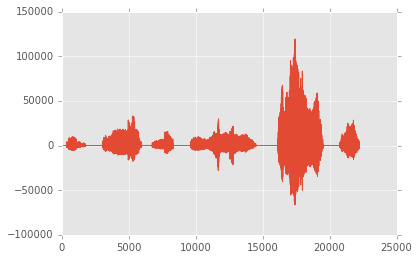

In [38]:
plt.plot(synth_bos[:m_length])

In [39]:
spectr, ax = plot_spectrogram(bos[:m_length], 
                                   0, 300, 30000,
                                   n_window = 192, n_overlap=192-1, scaling='spectrum')

ValueError: negative dimensions are not allowed

In [15]:
def list_shank_units(bird, sess, shank, shank_file=None, sorted=False):
    meta_dt = np.dtype([('sess', 'S32', 1), ('shank', np.int, 1), ('is_good', 'b', 1)])
    kwik_file = et.open_kwik(bird, sess) if shank_file is None else et.open_kwik(bird, sess, shank_file)
    group = int(shank)
    all_units = kwf.list_units(kwik_file, group=group, sorted=False)
    n_units = all_units.size
    all_meta = np.recarray(n_units, dtype=meta_dt)
    all_meta['sess'] = sess
    all_meta['shank'] = shank
    all_meta['is_good'] = True
    return rfn.merge_arrays((all_meta, all_units), asrecarray=True, flatten=True)

get_shanks_list = et.get_shanks_list

def list_sess_units(bird, sess, sorted=False):
    shanks = get_shanks_list(bird, sess)
    sess_units = None
    for shank in shanks:
        kwik_file = et.open_kwik(bird, sess)
        shank_units = list_shank_units(bird, sess, shank, sorted=False)
        if sess_units is None:
            sess_units = shank_units
        else:
            sess_units = rfn.stack_arrays((sess_units, shank_units))
    return sess_units

all_sess_units = list_sess_units(bird, sess)

In [34]:
# Neural data
shank = 0

kwik_file = et.open_kwik(bird, sess)
m_starts = kwf.apply_rec_offset(kwik_file, m.get_start(), m.get_rec())
#m_starts = m.get_start()
all_units = kwf.list_units(kwik_file, group=shank, sorted=False)

# this returns a numpy recarray with cols:
# group: site group (electrode shank)
# clu: cluster number
# qlt: sorting quality: 1 is MUA, 2 is well isolated (by default, only these 2 qlt's are returned)
# For instance, see all the clusters that are either mua or good units.
print all_units['clu']


[ 0  1 10 11 12 13 14 15 16 17 18 19  2 20 21 22 23 24 25 26 27 28 29  3 30
 31 32 33 34 35 36 37 38 39  4 40 41 42 43 44 45 46 47 48 49  5 50 51 52 53
 54 55 56 57 58 59  6 60 61 62 63  7  8  9]


selected unit 0


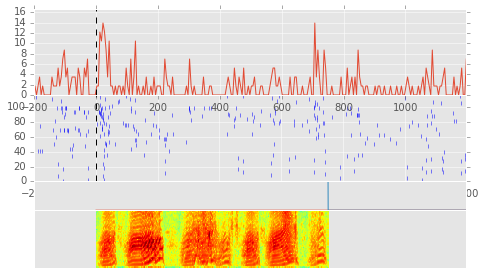

In [31]:
def plot_spectrogram(x, before_ms, after_ms, s_f, n_window = 192, n_overlap = None, sigma=None, ax=None, **kwargs):
    if n_overlap is None:
        n_overlap = n_window/2
    if sigma is None:
        sigma = 1./1000.*s_f
    
    # Make the spectrogram
    f, t, Sxx = spectrogram(x, s_f, nperseg = n_window, noverlap=n_overlap, window = sg.gaussian(n_window, sigma), scaling='spectrum')
    
    span_before = np.zeros((Sxx.shape[0], np.int(before_ms/1000. * s_f)))
    span_after = np.zeros((Sxx.shape[0], np.int(after_ms/1000. * s_f) - Sxx.shape[1]))
    span_before[:] = np.nan
    span_after[:] = np.nan
    #Sxx = np.hstack((span_before, (Sxx), span_after))
    
    if ax is None:
        spec_fig = plt.figure()
        ax = spec_fig.add_axes([0, 0, 1, 1])
        
    ax.pcolormesh(((t-0.5*n_window/s_f)*1000.), f, np.log(Sxx))
    ax.set_xlim(-before_ms, after_ms)
    ax.set_ylim(0,10000)
    #ax.plot((span_before.shape[1], span_before.shape[1]), (np.min(f), np.max(f)), 'k--')
    
    return Sxx, ax

def plot_waveform(x, before_ms, after_ms, s_f, ax=None):
    span_before = np.zeros(np.int(before_ms/1000. * s_f))
    span_before[:] = np.nan
    span_after = np.zeros(np.int(after_ms/1000. * s_f) - x.size)
    waveform_plot = np.insert(x, 0, span_before)
    waveform_plot = np.insert(span_after, 0, waveform_plot)
    waveform_t_plot = np.arange(waveform_plot.size)*1000./s_f
    if ax is None:
        raster_fig = plt.figure()
        ax = raster_fig.add_axes([0, 0, 1, 1])
    ax.plot(waveform_plot)
    ax.set_xlim(0, waveform_plot.size)
    ax.plot((span_before.size, span_before.size), (np.min(waveform_plot), np.max(waveform_plot)), 'k--')
    return ax

def plot_one_raster(unit_clu):
    # instance a Unit object
    unit = Unit(unit_clu, kwik_file=kwik_file)
    # get the spike times (in sample units)
    unit.get_time_stamps()
    # get the sampling rate of the recording
    s_f = unit.sampling_rate
    #get a raster for this unit around a window of [-2, 4] sec after each stimulus onset
    before_ms = 1000
    after_ms = 1600
    start_points = m_starts - np.int(s_f * before_ms/1000.) #start_points has to be in sample units
    rs = unit.get_raster(start_points, before_ms + after_ms, span_is_ms=True, return_ms=True)
    # the raster is an n_trial * m array (where m can be sample or ms).
    # in each row, it contains the timestamps (in samples or ms) of spikes relative to the beginning of the trial
    # plot the raster
    b = np.outer((np.arange(rs.shape[0]) + 1), np.ones(rs.shape[1]))
    plt.figure(unit_clu)
    plt.scatter(rs, b, marker='|')
    plt.xlim(0, before_ms + after_ms)
    plt.show
    
class VizUnit():
    def __init__(self, all_units, pattern_chunk, event, control=None):
        self.unit = None
        self.raster = None
        self.clu = all_units['clu']
        self.all_units = all_units
        self.is_good = Checkbox()
        self.fig = None
        self.fig_width = 1
        self.fig_ax = {}
        self.pattern_chunk = pattern_chunk
        self.pattern = pattern_chunk.data.reshape(pattern_chunk.data.size,)
        self.before_ms = 200
        self.after_ms = 1200
        self.start_points = None
        self.s_f = pattern_chunk.sound.s_f
        self.spectr = None
        self.event = None
        self.control=None
        self.control_start_points = None
        #display(self.is_bout)
        
        self.init_event(event)
        self.init_fig()
        
        if control is not None:
            self.init_control()
        
    def show(self, i):
        i_clu = i
        self.select_unit(i_clu)
        print 'selected unit {}'.format(i_clu)
        ax1 = self.fig_ax['raster']
        ax2 = self.fig_ax['histogram']
        ax1.cla()
        ax2.cla()
        rast, ax1 = plot_raster(sparse_raster(self.raster), t0=self.before_ms, ax=ax1)
        rast, ax2 = plot_raster(sparse_raster(self.raster), t0=self.before_ms, bin_size=5, ax=ax2)
        
        if self.control is not None:
            control_raster = 
        display(self.fig)
    
    def select_unit(self, unit_clu):
        self.unit = Unit(unit_clu, kwik_file=kwik_file)
        self.raster = self.unit.get_raster(self.start_points, self.before_ms + self.after_ms, 
                                           span_is_ms=True, return_ms=True)    
    def init_event(self, event):
        self.event = event
        m_starts = kwf.apply_rec_offset(kwik_file, self.event.get_start(), self.event.get_rec())
        self.start_points = m_starts - np.int(self.s_f * self.before_ms/1000.)
        
    def init_control(self, event):
        self.control = event
        m_starts = kwf.apply_rec_offset(kwik_file, self.control.get_start(), self.control.get_rec())
        self.control_start_points = m_starts - np.int(self.s_f * self.before_ms/1000.)
        
    def init_fig(self):
        self.fig = plt.figure()
        self.fig_ax['raster'] = self.fig.add_axes([0,.3,self.fig_width,0.3])
        self.fig_ax['histogram'] = self.fig.add_axes([0,.6,self.fig_width,0.3])
        self.fig_ax['spectrogram'] = self.fig.add_axes([0,0,self.fig_width,0.2])
        self.fig_ax['synthesis'] = self.fig.add_axes([0,.2,self.fig_width,0.1])
        for ax in self.fig_ax.itervalues():
            ax.xaxis.set_ticks([])
            ax.yaxis.set_ticks([])
        self.update_spectrogram()
        self.update_synth_plot()

    def update_spectrogram(self):
        ax = self.fig_ax['spectrogram']
        m_chunk = self.pattern_chunk
        self.spectr, ax = plot_spectrogram(m_chunk.data.reshape(m_chunk.data.size,), 
                                           self.before_ms, self.after_ms, m_chunk.sound.s_f, 
                                           ax=ax, 
                                           n_window = 192, n_overlap=192-1, scaling='spectrum')
    def update_synth_plot(self):
        ax = self.fig_ax['synthesis']
        ax = plot_waveform(alpha[192:,], self.before_ms, self.after_ms, m_chunk.sound.s_f, ax=ax)
        ax = plot_waveform(beta[192:,], self.before_ms, self.after_ms, m_chunk.sound.s_f, ax=ax)
        
        
        
    def bout_checked(self, bc):
#         print "bout checked"
#         print bc['new']
#         print self.motiff
        self.candidates.set_value(self.motiff, 'bout', bc['new'])
    # inspect the result

vu = VizUnit(all_units, m_chunk, m, m_control)
widgets.interact(vu.show, i=(0, all_units['clu'].size-1, 1))

In [46]:
all_units[62].clu

9

In [49]:
et.file_path(fn, 'ss_raw')

TypeError: file_path() takes exactly 3 arguments (2 given)

In [61]:
ls(et.file_path(fn, 'ss', 'ss_raw'))

/bin/sh: 1: Syntax error: "(" unexpected


In [12]:
kwd_f = h5py.File(et.file_path(fn, 'ss', 'ss_raw'), 'r')

In [10]:
fn

{'files': {'base': 'experiment',
  'cand': 'experiment.mot.h5',
  'mic': 'experiment-rec_000.mic.wav',
  'par': 'experiment.par.yml',
  'sng': 'experiment.sng.kwe',
  'ss_bin': 'experiment.raw.bin',
  'ss_raw': 'experiment.raw.kwd',
  'sts': 'experiment-rec_000.sts.wav'},
 'folders': {'kai': '/mnt/cube/kai/results/z020/day-2016-06-03',
  'raw': '/mnt/cube/earneodo/bci_zf/raw_data/z020/day-2016-06-03',
  'ss': '/mnt/cube/earneodo/bci_zf/ss_data/z020/day-2016-06-03',
  'stim': '/mnt/cube/earneodo/bci_zf/stim_data/z020/day-2016-06-03'}}

In [17]:
a_dset = kwd_f['/recordings/0/data']

In [32]:
a_dset.size/a_dset.shape[a_dset.ndim-1]

417856200.0

In [30]:
a_dset.shape[a_dset.ndim-1]

17

In [18]:
class H5Data:
    def __init__(self, h5_table, s_f, dtype=None):
        self.data_type = np.dtype(h5_table.dtype) if dtype is None else dtype
        self.s_f = s_f
        self.n_chans = h5_table.shape[h5_table.ndim-1]
        self.n_samples = int(h5_table.size/h5_table.shape[h5_table.ndim-1])
        self.table = h5_table

    def get_chunk(self, start, end, chan_list=[0]):
        assert (start >= 0)
        assert (end <= self.n_samples)
        assert (end > start)

        data = np.array(h5.load_table_slice(self.table, np.arange(start, end), chan_list),
                        dtype=self.data_type)
        return data



In [35]:
kwd_file = et.open_kwd(bird, sess)
starts = m.get_start()
recs = m.get_rec()

m_starts = kwf.apply_rec_offset(kwd_file, m.get_start(), m.get_rec())

i_bout = 5

neural_chans = np.array(exp_par['channel_config']['neural'][:32])
mic_chan = np.array(exp_par['channel_config']['mic'])
before = 0
after = 30000

#neural_chans = np.array([16])
rec = recs[i_bout]
dset = h5.get_data_set(kwd_file, rec)
h5d = H5Data(dset, s_f, dtype=np.float)
start = starts[i_bout]

lfp_frame = st.Chunk(h5d, (mic_chan), [start-before, start + m_chunk.samples + after])
#lfp_frame.plot()

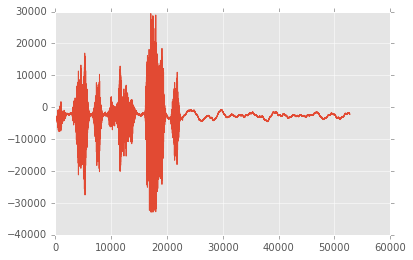

In [36]:
plt.plot(lfp_frame.data)

In [202]:
n_starts = m_starts.size
n_chans = neural_chans.size
n_samples = before + after + m_chunk.samples

sup_lfp = np.empty([n_chans, n_starts, n_samples], dtype=np.float)

for rec in np.unique(recs):
    dset = h5.get_data_set(kwd_file, rec)
    h5d = H5Data(dset, s_f, dtype=np.float)
    this_rec = np.where(recs==rec)[0]
    #print this_rec
    for i_trial, start in zip(this_rec, starts[this_rec]):
        #print i_trial
        sup_lfp[:, i_trial, :] = h5d.get_chunk(start-before, start + m_chunk.samples + after, neural_chans).T


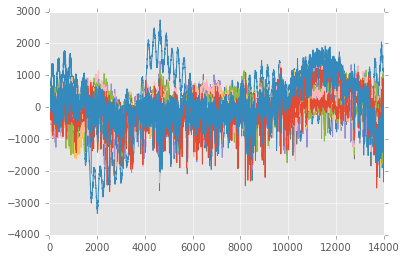

In [199]:
plt.plot(sup_lfp[:,7,:].T)